In [ ]:
!pip install mne
!pip install PyWavelets

from google.colab import drive
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt
import mne
import pywt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta

drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 52.1 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
gamedata_folders = ["game1", "game3", "game4", "game5", "game7", "game8", "game9", "game11", "game12", "game13", "game15", "game16"]

#gamedata_folders = ["game3", "game7", "game11", "game15"]

# gamedata_folders = ["gamedata_files_game1", "gamedata_files_game2", "gamedata_files_game3", "gamedata_files_game4"]
#Each game contains 21 minutes of data

# Old game data folders: "gamedata_files_game1", "gamedata_files_game2", "gamedata_files_game3", "gamedata_files_game4", "gamedata_files_game5", "gamedata_files_game6", "gamedata_files_game7"

In [ ]:
val_gamedata_folders = ["game2", "game6", "game10", "game14"]

In [ ]:
#gamedata_eegvalues = "/content/drive/MyDrive/EMOTIV-CSV-Files-Updated/Nov12-GameData-CSV-Files/gamedata_eegvalues_nov23.csv"
#gamedata_keystrokes = "/content/drive/MyDrive/EMOTIV-CSV-Files-Updated/Nov12-GameData-CSV-Files/gamedata_keystrokes_nov23.csv"

list_of_actions = ["up", "down", "left", "right"]

list_of_columns = ['EEG.AF3', 'EEG.F7', 'EEG.F3', 'EEG.FC5', 'EEG.T7', 'EEG.P7', 'EEG.O1', 'EEG.O2',
                   'EEG.P8', 'EEG.T8', 'EEG.FC6', 'EEG.F4', 'EEG.F8', 'EEG.AF4', 'Timestamp'] # Replace last element with 'Time of Day'

In [ ]:
def convert_time_to_unix(time, timestamp):
  return time

In [ ]:
from datetime import datetime
import mne

sfreq = 329

columns = [
    "AF3","F7","F3","FC5","T7","P7","O1","O2","P8","T8","FC6","F4","F8","AF4"
]

def group_by_time_of_day(data_eegvalues_path, data_keystrokes_path):
  df_keystrokes = pd.read_csv(data_keystrokes_path)
  df_eegvalues = pd.read_csv(data_eegvalues_path, delimiter=',') # The eeg values from CSV, but not as df

  # eegvalues_df = pd.DataFrame(df_eegvalues) # Actual eegvalues dataframe
  # info = mne.create_info(ch_names = columns, sfreq=sfreq, ch_types="eeg")
  # raw = mne.io.RawArray(eegvalues_df[columns].values.T, info)



  #df_eegvalues['Time of Day'] = pd.to_datetime(df_eegvalues['Timestamp'], unit='s')
  #df_eegvalues['Time of Day'] = df_eegvalues['Time of Day'].dt.tz_localize('UTC').dt.tz_convert('Asia/Bangkok')

  keystrokes_list = df_keystrokes.values.tolist()

  groups = {}
  print(f"keystrokes_list {keystrokes_list}")
  print(f"df_eegvalues {df_eegvalues}")
  print(f"keystrokes_list[0][0] {keystrokes_list[0][0]}")
  start_playing_time = convert_time_to_unix(keystrokes_list[0][1], df_eegvalues['TIMESTAMP'][0]) - keystrokes_list[0][0]

  for index, row in enumerate(keystrokes_list):
    if index == len(keystrokes_list) - 1:
      continue

    #TODO: convert end_time start_time to some time/datetime object
    start_time = keystrokes_list[index][0]
    end_time = keystrokes_list[index][1]

    group_time = df_eegvalues[(df_eegvalues['TIMESTAMP'] >= start_time) & (df_eegvalues['TIMESTAMP'] <= end_time)]
    print(len(group_time))
    if len(group_time) >= 800:
      group_time = group_time.iloc[0:800]
    else:
      continue
    if row[2] not in groups:
      groups[row[2]] = []
    groups[row[2]].append(group_time[columns].to_numpy())

    #groups['baseline']

  print("groups['baseline']", groups['baseline'][0].shape)
  baseline_array = np.array(groups['baseline'][0])


  baseline_mean = np.mean(baseline_array, axis=0)

  print("baseline_mean.shape = (14,)", baseline_mean.shape)

  for key in groups.keys():
    if key == 'baseline':
      continue
    for i in range(len(groups[key])):
      groups[key][i] = np.array(groups[key][i]) - baseline_mean

  return groups

In [ ]:
path_folder = "/content/drive/MyDrive/EMOTIV-CSV-Files-Updated/CSV-FILES-WITH-BASELINE"

df_list = []

for folder_num in range(1, len(gamedata_folders)+1):
  gamedata_eegvalues = f"{path_folder}/game{folder_num}/eeg_data{folder_num}.csv"
  gamedata_keystrokes = f"{path_folder}/game{folder_num}/game_data{folder_num}.csv"
  #try:
  df_gamedata = group_by_time_of_day(gamedata_eegvalues, gamedata_keystrokes)
  df_list.append(df_gamedata)

# Collect 5 sets of data at 5 different times

In [ ]:
path_folder = "/content/drive/MyDrive/EMOTIV-CSV-Files-Updated/CSV-FILES-WITH-BASELINE"

val_df_list = []

for folder_num in range(1, len(val_gamedata_folders)+1):
  gamedata_eegvalues = f"{path_folder}/game{folder_num}/eeg_data{folder_num}.csv"
  gamedata_keystrokes = f"{path_folder}/game{folder_num}/game_data{folder_num}.csv"
  #try:
  val_df_gamedata = group_by_time_of_day(gamedata_eegvalues, gamedata_keystrokes)
  val_df_list.append(val_df_gamedata)

# Collect 5 sets of data at 5 different times

In [ ]:
df_list[0]['down'][0]

In [ ]:
group_data = {}

for key in df_list[0].keys():
  group_data[key] = []
  for group in df_list:
    for item in group[key]:
      group_data[key].append(item)

In [ ]:
val_group_data = {}

for key in val_df_list[0].keys():
  val_group_data[key] = []
  for group in val_df_list:
    for item in group[key]:
      val_group_data[key].append(item)

In [ ]:
train_dict = {}
for key in ['right', 'up', 'down', 'left']:
   for i in range(len(df_list)):
      for item in df_list[i][key]:
        if key not in train_dict:
          train_dict[key] = []
        train_dict[key].append(item )
        train_dict[key].append(item )
        # val_dict[key].append(item[list_of_columns].values[400:600])
        # val_dict[key].append(item[list_of_columns].values[600:])

In [ ]:
val_dict = {}
for key in ['right', 'up', 'down', 'left']:
   for i in range(len(val_df_list)):
      for item in val_df_list[i][key]:
        if key not in val_dict:
          val_dict[key] = []
        val_dict[key].append(item )
        val_dict[key].append(item )
        # val_dict[key].append(item[list_of_columns].values[400:600])
        # val_dict[key].append(item[list_of_columns].values[600:])

In [ ]:
'''
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def normalize_data(data_dict):
    scaler = MinMaxScaler()
    normalized_dict = {}

    for class_name, series_list in data_dict.items():
      series_list = np.array(series_list)
      num_samples, timesteps, num_features = series_list.shape
      series_list = series_list.reshape(-1, num_features)
      series_list = scaler.fit_transform(series_list)
      series_list = series_list.reshape(num_samples, timesteps, num_features)
      normalized_dict[class_name] = series_list

    return normalized_dict, scaler

def prepare_data(data_dict, label_encoder):
    class_labels = list(data_dict.keys())
    label_encoder.fit(class_labels)

    X, y = [], []
    for class_name, series_list in data_dict.items():
        for series in series_list:
            X.append(series)
            y.append(label_encoder.transform([class_name])[0])

    X = np.array(X)
    y = np.array(y)

    # Shuffle data
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    return X, y, label_encoder

def build_gru_model(input_shape, num_classes):
    model = Sequential([
        GRU(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        GRU(32),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def plot_confusion_matrix(model, X_val, y_val, encoder):
    y_pred = np.argmax(model.predict(X_val), axis=1)
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)

    plt.figure(figsize=(6,6))
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

def downsample_by_mean(X_train, target_timesteps):
  n_samples, timesteps, num_channels = X_train.shape
  factor = timesteps // target_timesteps
  X_downsampled = X_train[:, :factor * target_timesteps, :].reshape(
      n_samples, target_timesteps, factor, num_channels
  ).mean(axis=2)
  return X_downsampled

label_encoder = LabelEncoder()

normalized_data_train, scaler = normalize_data(train_dict)
X_train, y_train, label_encoder = prepare_data(normalized_data_train, label_encoder)

normalized_data_val, scaler = normalize_data(val_dict)
X_val, y_val, label_encoder = prepare_data(normalized_data_val, label_encoder)

indices = np.arange(len(X_train))

np.random.shuffle(indices)
X_train = X_train[indices]
y_train = y_train[indices]

#new_timesteps = 256

#X_train = downsample_by_mean(X_train, new_timesteps)
#X_val = downsample_by_mean(X_val, new_timesteps)

input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = len(label_encoder.classes_)

model = build_gru_model(input_shape, num_classes)
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_val, y_val))

# Plot confusion matrix
plot_confusion_matrix(model, X_val, y_val, label_encoder)
'''

"\nimport numpy as np\nimport tensorflow as tf\nfrom sklearn.preprocessing import MinMaxScaler, LabelEncoder\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import GRU, Dense, Dropout\nfrom sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay\n\ndef normalize_data(data_dict):\n    scaler = MinMaxScaler()\n    normalized_dict = {}\n\n    for class_name, series_list in data_dict.items():\n      series_list = np.array(series_list)\n      num_samples, timesteps, num_features = series_list.shape\n      series_list = series_list.reshape(-1, num_features)\n      series_list = scaler.fit_transform(series_list)\n      series_list = series_list.reshape(num_samples, timesteps, num_features)\n      normalized_dict[class_name] = series_list\n\n    return normalized_dict, scaler\n\ndef prepare_data(data_dict, label_encoder):\n    class_labels = list(data_dict.keys())\n    label_encoder.fit(class_labels)\n\n    X, y = [], []\n    for class_name, series_list in

In [ ]:
import numpy as np
import scipy.signal
import torch
import torch.nn.functional as F

def eeg_to_spectrogram_tensor(
    eeg_raw,
    fs=128,
    nperseg=64,
    noverlap=32,
    resize_to=(64, 64),
    normalize=True,
    log_scale=True,
):
    """
    Chuyển tín hiệu EEG [T, 14] thành tensor ảnh [14, H, W] (dùng spectrogram)
    """
    n_channels = eeg_raw.shape[1]
    spectrograms = []

    for ch in range(n_channels):
        f, t, Sxx = scipy.signal.spectrogram(eeg_raw[:, ch], fs=fs, nperseg=nperseg, noverlap=noverlap)

        if log_scale:
            Sxx = np.log1p(Sxx)

        if normalize:
            mean = np.mean(Sxx)
            std = np.std(Sxx)
            Sxx = (Sxx - mean) / (std + 1e-8)

        # Resize từng ảnh về cùng kích thước nếu cần
        Sxx_resized = F.interpolate(
            input=torch.tensor(Sxx).unsqueeze(0).unsqueeze(0),  # [1, 1, F, T]
            size=resize_to,
            mode='bilinear',
            align_corners=False
        ).squeeze().numpy()  # [H, W]

        spectrograms.append(Sxx_resized)

    # Stack lại thành tensor [14, H, W]
    spec_tensor = np.stack(spectrograms, axis=0)
    return spec_tensor

In [ ]:
from tqdm import tqdm
import numpy as np
import pywt
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle

def prepare_data(data_dict, label_encoder):
    class_labels = list(data_dict.keys())
    label_encoder.fit(class_labels)
    X, y = [], []
    for class_name, series_list in train_dict.items():
      for series in tqdm(series_list):
        series = eeg_to_spectrogram_tensor(series)
        X.append(series)  # shape: (32, width, 1)
        y.append(label_encoder.transform([class_name])[0])

    X = np.array(X)
    y = np.array(y)

    # Shuffle
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    return X[indices], y[indices], label_encoder

# CNN model
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Confusion matrix plotting
def plot_confusion_matrix(model, X_val, y_val, encoder):
    y_pred = np.argmax(model.predict(X_val), axis=1)
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)

    plt.figure(figsize=(6,6))
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

label_encoder = LabelEncoder()

# Skip normalization — already handled by scalogram
X_train, y_train, label_encoder = prepare_data(train_dict, label_encoder)
X_val, y_val, label_encoder = prepare_data(val_dict, label_encoder)

# Save the label_encoder to a file
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
    print("Label Encoder has been saved to a file")



100%|██████████| 1070/1070 [00:09<00:00, 114.92it/s]


Label Encoder has been saved to a file


In [ ]:
# Get shape like (63, width, 1)
input_shape = X_train.shape[1:]
num_classes = len(label_encoder.classes_)

# Build and train CNN
cnn_model = create_cnn_model(input_shape, num_classes)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 28s 58ms/step - accuracy: 0.2477 - loss: 1.5537 - val_accuracy: 0.2582 - val_loss: 1.3853
Epoch 2/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.2601 - loss: 1.3886 - val_accuracy: 0.2586 - val_loss: 1.3922
Epoch 3/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2644 - loss: 1.4003 - val_accuracy: 0.2514 - val_loss: 1.3863
Epoch 4/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.2602 - loss: 1.3864 - val_accuracy: 0.2750 - val_loss: 1.3834
Epoch 5/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.2733 - loss: 1.3848 - val_accuracy: 0.2722 - val_loss: 1.3802
Epoch 6/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.2621 - loss: 1.3819 - val_accuracy: 0.2641 - val_loss: 1.3840
Epoch 7/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.2697 - loss: 1.3875 - val_accuracy: 0.2799 - val_loss: 1.3753
Epoch 8/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.2683 - loss: 1.3822 - val_accuracy

<Figure size 600x600 with 0 Axes>

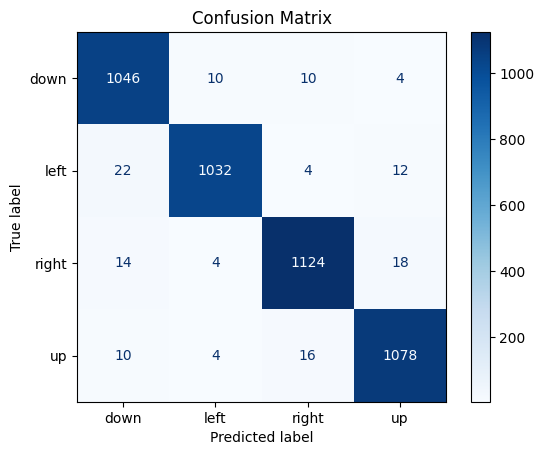

In [ ]:

history = cnn_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val))

# Plot confusion matrix
plot_confusion_matrix(cnn_model, X_val, y_val, label_encoder)

In [ ]:
#cnn_model.save("eeg_prediction_model.h5")
# Save the trained model to a .keras file
cnn_model.save("may25_mrquy_eeg_prediction_model.h5")
print("Model saved as may25_mrquy_eeg_prediction_model.h5")

Model saved as may25_mrquy_eeg_prediction_model.h5


In [ ]:
from google.colab import files
files.download('/content/eeg_prediction_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import random
import matplotlib.pyplot as plt

def plot_random_segment(data_dict, class_name, num_channels=14):
    if class_name not in data_dict or len(data_dict[class_name]) == 0:
        print(f"No data for {class_name}")
        return

    idx = random.randint(0, len(data_dict[class_name]) - 1)
    seg = data_dict[class_name][idx]  # shape (time_points, num_channels)

    plt.figure(figsize=(12, 5))
    for ch in range(num_channels):
        plt.plot(seg[:, ch], label=f'Ch{ch}')
    plt.title(f"Random {class_name} segment (index={idx}), shape={seg.shape}")
    plt.xlabel("Time points")
    plt.ylabel("EEG amplitude")
    plt.legend()
    plt.show()

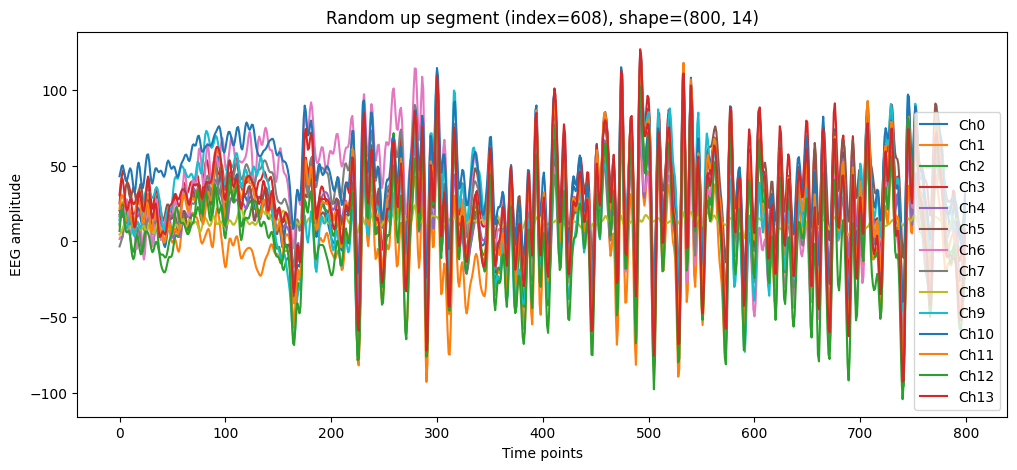

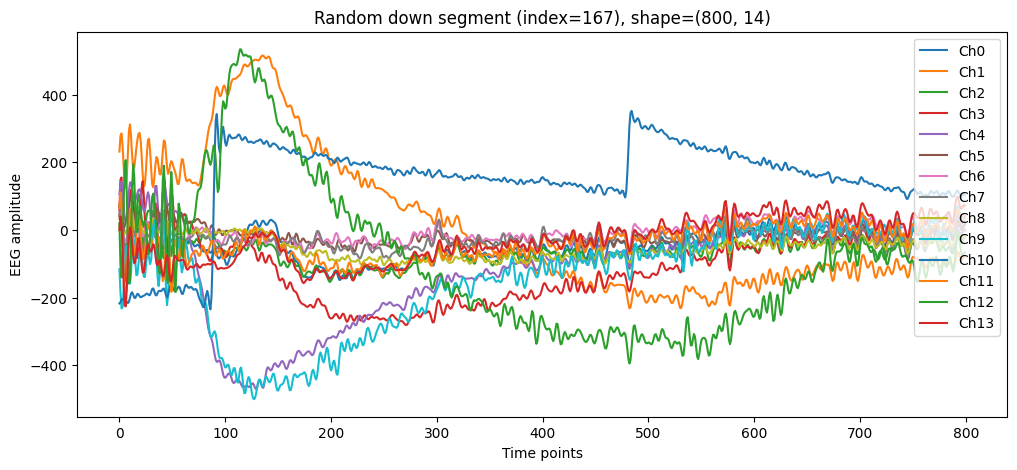

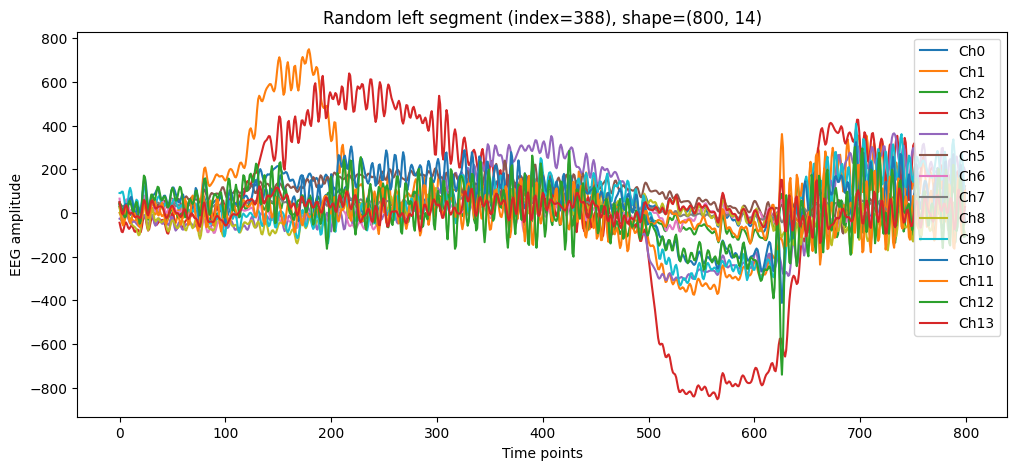

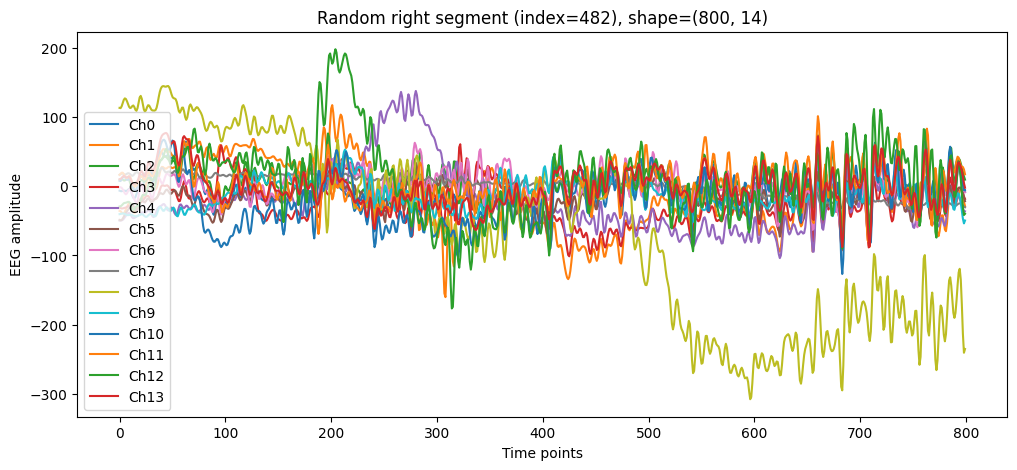

In [ ]:
plot_random_segment(train_dict, "up")
plot_random_segment(train_dict, "down")
plot_random_segment(train_dict, "left")
plot_random_segment(train_dict, "right")

In [ ]:
import random
import numpy as np

def print_random_segment_values(df_list,
                                directions=("up", "down", "left", "right"),
                                num_segments=1,
                                max_rows_to_print=10):
    """
    df_list:
      - a list of dictionaries where each dict has keys like 'up','down','left','right'
      - each key maps to a list of numpy arrays: shape (time_points, num_channels)

    directions:
      - which directions/classes to sample

    num_segments:
      - how many random segments to print per direction per game

    max_rows_to_print:
      - limit how many time points are printed per segment to avoid console overflow
    """

    for game_idx, game_dict in enumerate(df_list):
        print(f"\n=== Analyzing Game {game_idx+1} ===")

        for direction in directions:
            # Skip if no data for this direction in the current game
            if direction not in game_dict:
                print(f"  No data for '{direction}' in Game {game_idx+1}")
                continue

            seg_list = game_dict[direction]
            if len(seg_list) == 0:
                print(f"  No segments for '{direction}' in Game {game_idx+1}")
                continue

            # Print up to num_segments random ones
            for _ in range(num_segments):
                rand_idx = random.randint(0, len(seg_list) - 1)
                eeg_segment = seg_list[rand_idx]  # shape (time_points, num_channels)

                # Basic summary stats
                seg_min = np.min(eeg_segment)
                seg_max = np.max(eeg_segment)
                seg_mean = np.mean(eeg_segment)

                print(f"\nGame {game_idx+1} - {direction.upper()}, segment index = {rand_idx}")
                print(f"  Shape = {eeg_segment.shape} (time_points, channels)")
                print(f"  Min value = {seg_min:.3f}, Max value = {seg_max:.3f}, Mean value = {seg_mean:.3f}")

                # Print the first few rows of the array
                rows_to_print = min(max_rows_to_print, eeg_segment.shape[0])
                print(f"\n  First {rows_to_print} time points:")
                for i in range(rows_to_print):
                    # Print one row, e.g. [ch0, ch1, ...]
                    row_str = ", ".join(f"{val:.3f}" for val in eeg_segment[i])
                    print(f"    t={i}: [{row_str}]")

In [ ]:
print_random_segment_values(df_list, directions=["up","down","left","right"], num_segments=1, max_rows_to_print=10)


=== Analyzing Game 1 ===

Game 1 - UP, segment index = 43
  Shape = (800, 14) (time_points, channels)
  Min value = -63.358, Max value = 105.242, Mean value = 7.598

  First 10 time points:
    t=0: [16.337, 22.423, 17.245, -0.679, 29.851, 10.535, 22.732, 16.630, 18.237, 13.240, 21.663, 18.565, 50.370, 18.963]
    t=1: [10.183, 15.628, 11.989, -7.217, 24.082, 8.227, 20.296, 14.194, 15.544, 12.599, 15.894, 13.437, 48.062, 12.168]
    t=2: [4.670, 10.757, 9.296, -12.089, 18.697, 7.073, 16.835, 11.630, 13.108, 9.394, 10.509, 9.847, 44.344, 7.296]
    t=3: [0.311, 8.064, 8.271, -14.397, 15.492, 6.945, 14.655, 9.707, 11.442, 5.035, 6.022, 7.796, 39.601, 4.476]
    t=4: [-3.150, 6.398, 6.476, -15.038, 13.954, 6.432, 14.271, 9.066, 10.672, 1.317, 2.432, 6.514, 33.960, 2.296]
    t=5: [-5.971, 4.603, 4.681, -15.807, 13.056, 5.150, 14.399, 9.964, 11.442, 0.419, 0.765, 5.744, 29.857, 0.501]
    t=6: [-7.381, 2.936, 5.835, -16.448, 12.672, 3.868, 14.527, 13.553, 14.647, 3.368, 2.945, 7.283, 30.4

In [ ]:
# APRIL 6, 2025 - STOP CODE HERE

In [ ]:
import numpy as np
import pywt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def normalize_data(data_dict):
    scaler = MinMaxScaler()
    normalized_dict = {}

    for class_name, series_list in data_dict.items():
      series_list = np.array(series_list)
      num_samples, timesteps, num_features = series_list.shape
      series_list = series_list.reshape(-1, num_features)
      series_list = scaler.fit_transform(series_list)
      series_list = series_list.reshape(num_samples, timesteps, num_features)
      normalized_dict[class_name] = series_list

    return normalized_dict, scaler

def prepare_data(data_dict, label_encoder):
    class_labels = list(data_dict.keys())
    label_encoder.fit(class_labels)

    X, y = [], []
    for class_name, series_list in data_dict.items():
        for series in series_list:
            X.append(series)
            y.append(label_encoder.transform([class_name])[0])

    X = np.array(X)
    y = np.array(y)

    # Shuffle data
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    return X, y, label_encoder

def build_gru_model(input_shape, num_classes):
    model = Sequential([
        GRU(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        GRU(32),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def plot_confusion_matrix(model, X_val, y_val, encoder):
    y_pred = np.argmax(model.predict(X_val), axis=1)
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)

    plt.figure(figsize=(6,6))
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

def downsample_by_mean(X_train, target_timesteps):
  n_samples, timesteps, num_channels = X_train.shape
  factor = timesteps // target_timesteps
  X_downsampled = X_train[:, :factor * target_timesteps, :].reshape(
      n_samples, target_timesteps, factor, num_channels
  ).mean(axis=2)
  return X_downsampled



label_encoder = LabelEncoder()

normalized_data_train, scaler = normalize_data(train_dict)
X_train, y_train, label_encoder = prepare_data(normalized_data_train, label_encoder)

normalized_data_val, scaler = normalize_data(val_dict)
X_val, y_val, label_encoder = prepare_data(normalized_data_val, label_encoder)

indices = np.arange(len(X_train))

np.random.shuffle(indices)
X_train = X_train[indices]
y_train = y_train[indices]

new_timesteps = 256

X_train = downsample_by_mean(X_train, new_timesteps)
X_val = downsample_by_mean(X_val, new_timesteps)

input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = len(label_encoder.classes_)

# Hàm biến đổi wavelet
def wavelet_transform(data, wavelet='db4', level=3):
    batch_size, timesteps, channels = data.shape
    coeffs = []

    # Lặp qua từng batch và từng kênh
    for i in range(batch_size):
        channel_coeffs = []
        for j in range(channels):
            signal = data[i, :, j]
            wavelet_coeffs = pywt.wavedec(signal, wavelet, level=level)

            max_length = max([len(coeff) for coeff in wavelet_coeffs])

            padded_coeffs = [np.pad(coeff, (0, max_length - len(coeff)), 'constant') for coeff in wavelet_coeffs]
            channel_coeffs.append(padded_coeffs)

        coeffs.append(channel_coeffs)

    return np.array(coeffs)

# Hàm trích xuất đặc trưng từ hệ số wavelet
def extract_wavelet_features(coeffs):
    batch_size, channels, levels = coeffs.shape[0], coeffs.shape[1], coeffs.shape[2]
    features = []

    # Chuyển đổi hệ số wavelet thành các ma trận có thể sử dụng cho CNN
    for i in range(batch_size):
        wavelet_matrix = []
        for j in range(channels):
            channel_coeffs = coeffs[i, j]
            wavelet_matrix.append(np.concatenate(channel_coeffs, axis=0))  # Nối các hệ số lại với nhau
        features.append(np.stack(wavelet_matrix, axis=-1))  # Tạo ma trận có dạng (timesteps, channels)

    return np.array(features)

# # Giả sử dữ liệu EEG có dạng (batch, timesteps, channels)
# batch_size = 100
# timesteps = 1000
# channels = 3
# data = np.random.randn(batch_size, timesteps, channels)

# # Gắn nhãn cho dữ liệu giả (0 hoặc 1)
# labels = np.random.randint(0, 2, batch_size)

# Biến đổi wavelet
coeffs_train = wavelet_transform(X_train)

# Trích xuất đặc trưng wavelet
X_train = extract_wavelet_features(coeffs_train)

coeffs_val = wavelet_transform(X_val)

# Trích xuất đặc trưng wavelet
X_val = extract_wavelet_features(coeffs_val)

# Chia dữ liệu thành tập huấn luyện và kiểm tra
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = len(label_encoder.classes_)

model = build_gru_model(input_shape, num_classes)
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_val, y_val))

# Plot confusion matrix
plot_confusion_matrix(model, X_val, y_val, label_encoder)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.2636 - loss: 1.3871

KeyboardInterrupt: 

In [ ]:
import joblib
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Save the trained model
model.save("mar20_eeg_to_game_model.h5")
joblib.dump(scaler, "mar20_eeg_data_scaler.pkl")
joblib.dump(label_encoder, "mar20_label_encoder.pkl")

In [ ]:
!pip install mne

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import mne
import pandas as pd

sfreq = 329

columns = [
    "AF3","F7","F3","FC5","T7","P7","O1","O2","P8","T8","FC6","F4","F8","AF4"
]

data = "/content/drive/MyDrive/EMOTIV-CSV-Files-Updated/CORRECT-CSV-Files-Updated/Mar22_Game1/eeg_data7.csv"

eeg_data = pd.read_csv(data)

df = pd.DataFrame(eeg_data)

info = mne.create_info(ch_names = columns, sfreq=sfreq, ch_types="eeg")

raw = mne.io.RawArray(df[columns].values.T, info)
raw.plot()

In [ ]:
import joblib
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from scipy.signal import butter, filtfilt

# Load the trained model, scaler, and label encoder
model = load_model("mar20_eeg_to_game_model.h5")
scaler = joblib.load("mar20_eeg_data_scaler.pkl")
label_encoder = joblib.load("mar20_label_encoder.pkl")

# List of EEG sensor columns (same as during training)
list_of_columns = ['EEG.AF3', 'EEG.F7', 'EEG.F3', 'EEG.FC5', 'EEG.T7', 'EEG.P7', 'EEG.O1', 'EEG.O2',
                   'EEG.P8', 'EEG.T8', 'EEG.FC6', 'EEG.F4', 'EEG.F8', 'EEG.AF4']

# Frequency bands (same as used in training)
frequency_bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (12, 35),
    'gamma': (35, 40)
}

# Function to apply bandpass filter safely
def bandpass_filter(data, lowcut, highcut, fs=128, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist

    if low <= 0 or high >= 1:
        raise ValueError("Digital filter critical frequencies must be 0 < Wn < 1")

    # Ensure the data length is sufficient for filtering
    min_length = 3 * order  # Minimum required length for filtfilt()
    if len(data) < min_length:
        return np.zeros(len(data))  # Return zeros if the signal is too short

    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Function to process EEG data into frequency bands
def data_waves_transformation(df_eeg):
    list_data_waves = []

    for _, row in df_eeg.iterrows():
        sensors = []
        for sensor in list_of_columns:
            data = np.array([row[sensor]])  # Convert to NumPy array
            band_features = []

            for band, (low, high) in frequency_bands.items():
                filtered_data = bandpass_filter(data, low, high)
                magnitude_spectrum = np.log1p(np.abs(np.fft.fft(filtered_data)))
                band_features.append(magnitude_spectrum)

            sensors.append(band_features)

        list_data_waves.append(sensors)

    return np.array(list_data_waves)

# Load EEG Data
eeg_data_path = "/content/drive/MyDrive/EMOTIV-CSV-Files-Updated/CORRECT-CSV-Files-Updated/gamedata_files_game1/eeg_data1.csv"
df_eeg = pd.read_csv(eeg_data_path)

# Select relevant EEG sensor columns
df_eeg = df_eeg[list_of_columns]

# Normalize EEG data using the same scaler from training
eeg_values = df_eeg.values
eeg_values = scaler.transform(eeg_values)

# Reshape into sequences of 800 time steps (same as training)
seq_length = 800
num_samples = len(eeg_values) // seq_length
eeg_sequences = np.array([eeg_values[i * seq_length:(i + 1) * seq_length] for i in range(num_samples)])

# Predict
predictions = model.predict(eeg_sequences)
predicted_labels = np.argmax(predictions, axis=1)
predicted_actions = label_encoder.inverse_transform(predicted_labels)

# Save predictions to a CSV file
output_path = "mar22_game1_gamedata1.csv"
df_output = pd.DataFrame({"Predicted Action": predicted_actions})
df_output.to_csv(output_path, index=False)

print(f"Predictions saved to {output_path}")

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Load the training dataset class distribution
class_counts = {key: len(val_dict[key]) for key in val_dict.keys()}

# Plot class distribution
plt.figure(figsize=(8,5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Game Actions")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Training Data")
plt.show()

# Print class counts
print("Class distribution in training data:", class_counts)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Select minimum samples per class for fair visualization
num_samples_per_class = min([len(val_dict[class_name]) for class_name in val_dict.keys()])

fig, axes = plt.subplots(len(val_dict.keys()), 1, figsize=(12, 10))
for i, class_name in enumerate(val_dict.keys()):
    eeg_sample = np.mean(np.array(val_dict[class_name][:num_samples_per_class]), axis=0)  # Averaging over multiple samples
    axes[i].plot(eeg_sample.mean(axis=1), label=f"Avg EEG {class_name}")  # Plotting average across sensors
    axes[i].set_title(f"EEG Data Distribution for {class_name}")
    axes[i].legend()

plt.tight_layout()
plt.show()

**Reason for Differing Confusion Matrices for Different Validation Datasets** = different baselines (and maybe different EEG qualities), which result in different EEG values

--> **IMPORTANT: REMOVE BASELINE FROM DATA IN ORDER TO MAKE THE EEG VALUES THE SAME (AS SIMILAR AS POSSIBLE) ACROSS VALIDATION DATASETS**

In [ ]:
# Feb16_Game1
path_folder = "/content/drive/MyDrive/EMOTIV-CSV-Files-Updated/CORRECT-CSV-Files-Updated"

val_df_list = []

folder_num  = 'Feb18_Game2'
gamedata_eegvalues = f"{path_folder}/{folder_num}/eeg_data4.csv"
gamedata_keystrokes = f"{path_folder}/{folder_num}/game_data4.csv"
#try:
val_df_gamedata = group_by_time_of_day(gamedata_eegvalues, gamedata_keystrokes)
val_df_list.append(val_df_gamedata)

In [ ]:
def prepare_data(data_dict, label_encoder):
    class_labels = list(data_dict.keys())

    X, y = [], []
    for class_name, series_list in data_dict.items():
        for series in series_list:
            X.append(series)
            y.append(label_encoder.transform([class_name])[0])

    X = np.array(X)
    y = np.array(y)

    # Shuffle data
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    return X, y, label_encoder

def normalize_data(data_dict):
    scaler = MinMaxScaler()
    normalized_dict = {}
    for class_name, series_list in data_dict.items():
        series_list = np.array(series_list)
        num_samples, timesteps, num_features = series_list.shape
        series_list = series_list.reshape(-1, num_features)
        series_list = scaler.fit_transform(series_list)
        series_list = series_list.reshape(num_samples, timesteps, num_features)
        normalized_dict[class_name] = series_list

    return normalized_dict, scaler

In [ ]:
val_data_dict = {}
for key in ['right', 'up', 'down', 'left']:
   for i in range(len(val_df_list)):
      for item in val_df_list[i][key]:
        if key not in val_data_dict:
          val_data_dict[key] = []
        val_data_dict[key].append(item[list_of_columns].values)
        val_data_dict[key].append(item[list_of_columns].values)

In [ ]:
val_data_dict

In [ ]:
normalized_data = normalize_data(val_data_dict)
X_val, y_val, _ = prepare_data(normalized_data[0], label_encoder)

plot_confusion_matrix(model, X_val, y_val, label_encoder)

In [ ]:
normalized_data[0].keys()

In [ ]:
# Plot confusion matrix
X_val, y_val = X[int(len(X) * 0.8):], y[int(len(y) * 0.8):]
plot_confusion_matrix(model, X_val, y_val, label_encoder)

In [ ]:
groups_transformed = {}
for action, group_list in group_data.items():
  groups_transformed[action] = data_waves_transformation(group_list)

In [ ]:
def prepare_data(groups_transformed):
    data, labels = [], []
    for label, action in enumerate(list_of_actions):
        for group in groups_transformed[action]:
            data.append(group)
            labels.append(label)
    return np.array(data), np.array(labels)

In [ ]:
X, y = prepare_data(groups_transformed)

In [ ]:
import random

def split_data_by_time(groups):
  num_data = len(groups)
  num_train = int(num_data * 0.8)
  num_test = num_data - num_train

  groups_train = groups[:num_train]
  groups_test = groups[num_train:]

  random.shuffle(groups_train)
  random.shuffle(groups_test)

  return groups_train, groups_test

In [ ]:
groups_train = {}
groups_test = {}

for action in groups_transformed:
  groups_train[action], groups_test[action] = split_data_by_time(groups_transformed[action])

In [ ]:
def remove_dc_offset_and_reshape(data):
    """
    data: A list (or array) of shape (num_samples, 14, 5, 128).
          We convert to a NumPy array, normalize per sample,
          and transpose to (num_samples, 128, 14, 5).

    Returns the normalized, reshaped array.
    """
    # 1) Convert from list to numpy array if needed
    data = np.array(data, dtype=np.float32)

    # data.shape is now (num_samples, 14, 5, 128)
    num_samples = data.shape[0]

    # 2) Per-sample mean/std normalization
    for i in range(num_samples):
        sample = data[i]  # shape: (14, 5, 128)
        sample_mean = np.mean(sample)
        sample_std = np.std(sample)
        data[i] = (sample - sample_mean) / (sample_std + 1e-9)

    # 3) Transpose to get (num_samples, 128, 14, 5)
    #    That is: axis 0 = sample index,
    #             axis 3 (time=128) -> axis 1,
    #             axis 1 (14)       -> axis 2,
    #             axis 2 (5)        -> axis 3.
    data = data.transpose(0, 3, 1, 2)  # (0,3,1,2) means: keep 0 in place, move 3 to axis1, move 1 to axis2, move 2 to axis3

    return data
'''
def remove_dc_offset_and_reshape(data):
  data = data - np.mean(data)
  data = data / np.max(np.abs(data))

  return data.reshape(data.shape[0], 128, 14, 5)
'''

In [ ]:
for action in groups_train:
  groups_train[action] = remove_dc_offset_and_reshape(groups_train[action])
for action in groups_test:
  groups_test[action] = remove_dc_offset_and_reshape(groups_test[action])

In [ ]:
X_train = np.concatenate(list(groups_train.values()))
y_train = np.concatenate([np.full(len(groups_train[action]), i) for i, action in enumerate(list_of_actions)])
X_test = np.concatenate(list(groups_test.values()))
y_test = np.concatenate([np.full(len(groups_test[action]), i) for i, action in enumerate(list_of_actions)])

In [ ]:
def create_model(input_shape=(400, 14, 5), num_actions=len(list_of_actions)):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_actions, activation='softmax'))
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

model = create_model()
model.summary()

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
def split_X_train(X_train):
    """
    Chia nhỏ X_train có shape (492, 800, 14, 5) thành (984, 400, 14, 5)
    """
    if X_train.shape[1] % 2 != 0:
        raise ValueError("Kích thước chiều thứ 2 của X_train phải chia hết cho 2")

    X_split = np.concatenate(np.split(X_train, 2, axis=1), axis=0)
    return X_split

In [ ]:
X_train = split_X_train(X_train)
X_test = split_X_train(X_test)


In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(list_of_actions))
y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(list_of_actions))

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

eval_results = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {eval_results[0]}, Test Accuracy: {eval_results[1]}")

def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
from sklearn import metrics

actual = np.argmax(y_test, axis=1)
predicted = np.argmax(model.predict(X_test), axis=1)

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=list_of_actions)
cm_display.plot()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/EMOTIV-CSV-Files-Updated/Dec30-GameData-CSV-Files/dec30_gamedata_model.h5')

In [ ]:
cols = [
    "COUNTER",
    "INTERPOLATED",
    "AF3","F7","F3","FC5","T7","P7","O1","O2","P8","T8","FC6","F4","F8","AF4",
    "RAW_CQ",
    "MARKER_HARDWARE",
    "MARKERS"
]

In [ ]:
cols[2:16]

['AF3',
 'F7',
 'F3',
 'FC5',
 'T7',
 'P7',
 'O1',
 'O2',
 'P8',
 'T8',
 'FC6',
 'F4',
 'F8',
 'AF4']